In [40]:
#convert the longitudinal blood pressure measurements into a proper time series

import pandas as pd

long_data = pd.read_csv('patient_longitudinal.csv', sep='\t')
long_data['visit_date'] = pd.to_datetime(long_data['visit_date'], format='%Y-%m-%d')

#check for duplicates
long_data[long_data.duplicated(['patient_id'])]

#replace duplicates with mean using aggregation 
long_data = long_data.groupby('patient_id').mean().reset_index()

#set visit_data as index 
long_data.set_index('visit_date', inplace=True)

#check for missing values
long_data.isnull().sum()

long_data


,patient_id,bp_systolic,heart_rate,adverse_event,age,sex,bmi,smoking,diabetes
visit_date,,,,,,,,,
2024-01-15 12:00:00,0,110.850,79.100,0.00,57.5,0.0,25.8,0.0,0.0
2024-01-15 12:00:00,1,144.400,80.475,0.00,47.9,0.0,23.2,0.0,0.0
2024-01-15 12:00:00,2,136.150,83.775,0.00,59.7,1.0,29.0,0.0,0.0
2024-01-15 12:00:00,3,143.825,76.950,0.00,72.8,1.0,34.6,0.0,1.0
2024-01-15 12:00:00,4,125.300,92.625,0.00,46.5,0.0,17.5,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2024-01-15 12:00:00,995,117.075,75.575,0.00,45.8,0.0,23.6,0.0,0.0
2024-01-15 12:00:00,996,142.175,76.400,0.25,77.0,0.0,22.1,0.0,1.0
2024-01-15 12:00:00,997,143.225,53.925,0.00,59.6,1.0,22.2,0.0,1.0


In this first part of the problem, i loaded the patient_longitudinal dataset and then added a seperate column named visit_date. I then checked for duplicates and saw that we have 3000 duplicates. I then used aggregation by patient_id calculating the mean numeric columns. I then set the visit_date column as index for time series analysis. I also checked for missing values but there were none. 

/tmp/ipykernel_12964/3565933119.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_bp = long_data['bp_systolic'].resample('M').mean()


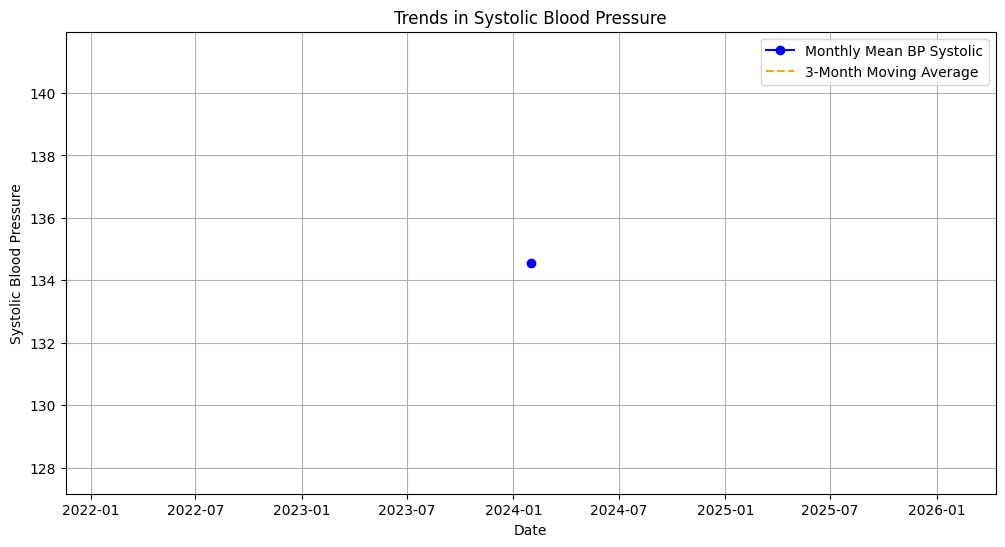

In [41]:
#analyze blood pressure trends 

import matplotlib.pyplot as plt

#month-end frequency 
monthly_bp = long_data['bp_systolic'].resample('M').mean()

#calculate the 3 month moving average
monthly_moving_avg = monthly_bp.rolling(window=3, min_periods=1).mean()

#fill the gaps
monthly_bp = monthly_bp.interpolate()
monthly_moving_avg = monthly_moving_avg.interpolate()

plt.figure(figsize=(12, 6))
plt.plot(monthly_bp, label='Monthly Mean BP Systolic', color='blue', marker='o', linestyle='-')
plt.plot(monthly_moving_avg, label='3-Month Moving Average', color='orange', linestyle='--')
plt.title('Trends in Systolic Blood Pressure')
plt.xlabel('Date')
plt.ylabel('Systolic Blood Pressure')
plt.legend()
plt.grid()
plt.show()

In [55]:
long_data



,patient_id,bp_systolic,heart_rate,adverse_event,age,sex,bmi,smoking,diabetes
visit_date,,,,,,,,,
2024-01-15 12:00:00,0,110.850,79.100,0.00,57.5,0.0,25.8,0.0,0.0
2024-01-15 12:00:00,1,144.400,80.475,0.00,47.9,0.0,23.2,0.0,0.0
2024-01-15 12:00:00,2,136.150,83.775,0.00,59.7,1.0,29.0,0.0,0.0
2024-01-15 12:00:00,3,143.825,76.950,0.00,72.8,1.0,34.6,0.0,1.0
2024-01-15 12:00:00,4,125.300,92.625,0.00,46.5,0.0,17.5,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2024-01-15 12:00:00,995,117.075,75.575,0.00,45.8,0.0,23.6,0.0,0.0
2024-01-15 12:00:00,996,142.175,76.400,0.25,77.0,0.0,22.1,0.0,1.0
2024-01-15 12:00:00,997,143.225,53.925,0.00,59.6,1.0,22.2,0.0,1.0
